#### Animations of velocity fields (raw and demodulated)

In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp
import pyinterp

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.7697841.datarmor0/parcels-502090/libparcels_random_cc899406-1c17-4d05-8bb5-3c89a351c7fe.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=2
                 )
#
client = Client(cluster)

In [3]:
isel = dict(face=7)
sel = dict(i=slice(2700,2900), j=slice(2900,3100))#, i_g=slice(3000,3100), j_g=slice(3000,3100)) # North East Hawaii
#sel = dict(i=[3000,3010], j=[3000,3010], i_g=[3000,3010], j_g=[3000,3010]) # North East Hawaii

In [4]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

In [5]:
ds = xr.merge([xr.open_zarr(ut.work_data_dir+'rechunked/SSU.zarr'),xr.open_zarr(ut.work_data_dir+'rechunked/SSV.zarr'),
               xr.open_zarr(ut.work_data_dir+'rechunked/Eta.zarr')
              ])
grd = ut.load_grd()[['XC', 'YC', 'Depth']].persist()

In [6]:
ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC
ds = ds.drop(['i_g','j_g']).rename({'i_g':'i','j_g':'j'})

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    

In [7]:
dsp = ds.isel(**isel).sel(**sel)

dsp = dsp.chunk({"time": -1}).persist() #,"i":10,"j":10
dsp

<xarray.Dataset>
Dimensions:  (i: 101, j: 101, time: 8784)
Coordinates:
  * i        (i) int64 2700 2702 2704 2706 2708 ... 2892 2894 2896 2898 2900
  * j        (j) int64 2900 2902 2904 2906 2908 ... 3092 3094 3096 3098 3100
    face     int64 7
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-14T23:00:00
    XC       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
Data variables:
    SSU      (time, j, i) float32 dask.array<chunksize=(8784, 86, 90), meta=np.ndarray>
    SSV      (time, j, i) float32 dask.array<chunksize=(8784, 86, 90), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(8784, 86, 90), meta=np.ndarray>
    lon      (j, i) float64 dask.array<chunksize=(101, 101), meta=np.ndarray>
    lat      (j, i) float64 dask.array<chunksize=(101, 101), meta=np.ndarray>

In [8]:
dsp['zonal_velocity'] = dsp['SSU']*dsp.CS - dsp['SSV']*dsp.SN
dsp['meridional_velocity'] =  dsp['SSU']*dsp.SN + dsp['SSV']*dsp.CS
dsp = dsp.assign_coords({'lon':dsp.lon,'lat':dsp.lat})
dsp = dsp.drop(['SSU','SSV']).persist()



In [9]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [10]:
def wrap_filter(_ds,om,Tw,dband,V,dt=dt):
    h = sp.generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)
    time = np.arange(0,_ds['time'].values.size*dt,dt)
    exp = np.exp(-1j*omega*2*np.pi*time)
    ds_hat={}
    for v in V:
        ds_hat[v+'_hat'] = filt(_ds[v], h,hilbert=True).persist()
        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
        ds_hat[v+'_demodulated'] = ds_hat[v+'_hat']*exp
        ds_hat[v+'_demodulated_real']=ds_hat[v+'_demodulated'].real
        ds_hat[v+'_demodulated_imag']=ds_hat[v+'_demodulated'].imag
    ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()])
    return ds_hat,h
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'T_window':T_window,'bandwidth':[b*2 for b in bandwidths]})

In [11]:
V = ['zonal_velocity','meridional_velocity','Eta']
Tw = 30
dband=0.2 #half bandwidth

In [12]:
ds_hat,h = wrap_filter(dsp,omega,Tw,dband,V)

In [13]:
h_hat, w = sp.filter_response(h, dt=dt)

No handles with labels found to put in legend.


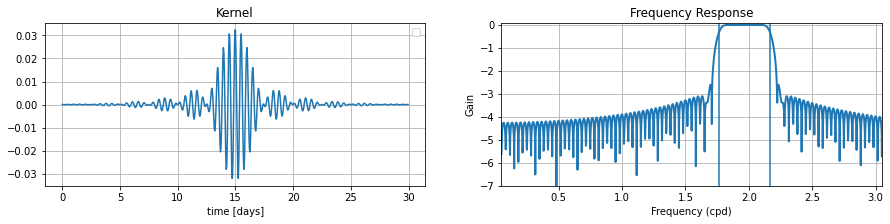

In [14]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
    #t = np.arange(0, h.size)*dt
t = np.arange(0, h.size)*dt
ax.plot(t, h);
ax.grid();
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()
ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-dband)#, color='k')
ax.axvline(omega+dband)#, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)
    #H.plot.line(hue='T_window')

In [15]:
#it = int(20/dt)
v='zonal_velocity'
def gen_figs(ds_hat,it,v,savefig=False):
    name=v+'_%s'%it
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    ds_hat[v+'_demodulated_real'].isel(time=it).plot(ax=ax[1],x='lon',y='lat',vmax=0.3,vmin=-0.3,cmap='RdBu_r',
                                                        cbar_kwargs={'label':'demodulated'+v+' : real part'})
    ds_hat[v+'_demodulated_imag'].isel(time=it).plot(ax=ax[2],x='lon',y='lat',vmax=0.3,vmin=-0.3,cmap='RdBu_r',
                                                         cbar_kwargs={'label':'demodulated'+v+' : imaginary part'})
    dsp[v].isel(time=it).plot(ax=ax[0],x='lon',y='lat',vmax=0.3,vmin=-0.3,cmap='RdBu_r'
                             )#,x='lon',y='lat'
    for a in ax:
        a.set_title('Time : %s'%dsp[v].isel(time=it).time.values.astype('M8[s]'))
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/raw_demodulated_itide/'+name+'.jpg')
        plt.close()


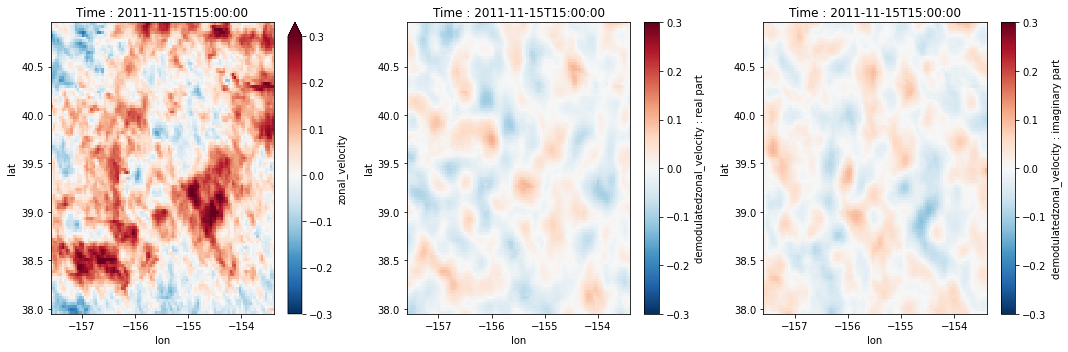

In [16]:
it=15
gen_figs(ds_hat,it,v)

In [20]:
IT = np.arange(0,366/dt,12)
for it in IT:
    gen_figs(ds_hat,int(it),v,savefig=True)

### Add drifters

In [16]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
parcels_index = 'time'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df = pa.degs2ms(df)
df.head()

trajectory        lat         lon    z  zonal_velocity  \
time                                                                 
2011-11-15    39000000  57.835732 -178.867081  0.0             0.0   
2011-11-15    39000001  58.429878 -178.871994  0.0             0.0   
2011-11-15    39000002  59.018066 -178.879623  0.0             0.0   
2011-11-15    39000003  59.600288 -178.890015  0.0             0.0   
2011-11-15    39000004  60.176525 -178.903275  0.0             0.0   

            meridional_velocity  sea_level  temperature  salinity  
time                                                               
2011-11-15                  0.0        0.0          0.0       0.0  
2011-11-15                  0.0        0.0          0.0       0.0  
2011-11-15                  0.0        0.0          0.0       0.0  
2011-11-15                  0.0        0.0          0.0       0.0  
2011-11-15                  0.0        0.0          0.0       0.0

In [17]:
lonmin,lonmax,latmin,latmax = dsp.lon.min().values,dsp.lon.max().values,dsp.lat.min().values,dsp.lat.max().values

In [18]:
# extract relevant trajectory indices
bbox=[lonmin,lonmax,latmin,latmax]
_df = df[ (df.lon>=bbox[0])
        &(df.lon<=bbox[1])
        &(df.lat>=bbox[2])
        &(df.lat<=bbox[3])
       ]
traj = _df.drop_duplicates(subset=["trajectory"]).compute()["trajectory"]
#traj = _df.index.drop_duplicates(keep='first').compute()#["index"]

df_selected = df[df.trajectory.isin(traj)]

In [19]:
def remove_duplicates(df):
    df = df.reset_index().drop_duplicates('time').sort_values('time').set_index('time')
    return df
def filt_L(v, h,columns, hilbert=False):
    vc = v.copy()
    for V in columns:
        vc[V+'_hat'] = convolve(vc[V],h,hilbert=hilbert)
    time = np.arange(0,vc.index.size*dt,dt)#.compute()
    exp = np.exp(-1j*omega*2*np.pi*time)
    for V in columns:
        vc[V+'_demodulated'] = vc[V+'_hat']*exp
    #output_dtype = complex if hilbert else float
    #gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return vc#xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
            #        dask='parallelized', output_dtypes=[output_dtype],
            #       input_core_dims=[['time']],
            #        output_core_dims=[['time']],
            #       dask_gufunc_kwargs = gufunc_kwargs,
            #            )

In [20]:
def interp_trajectories(df_sub,ds,v):
    """
    Interpolate Eulerian mean field over simulated drifters trajectories usin inverse distance weigthing method.
    
    Parameters:
    ----------
    df_sub : dask dataframe
    v : Variable to be interpolated
    Returns:
    ----------
    df_sub : input dask dataframe with an additional column of interpolated field
    """     
    #grd = ut.load_grd(V=['XC','YC','CS','SN'])
    #diags_dir = '/home/datawork-lops-osi/equinox/mit4320/diags/'
    #if np.isin(v,['SSU','SSV']):
        #ds = xr.merge([ut.load_diagnostic("mean_"+V) for V in ['SSU','SSV']])
        #ds = xr.open_zarr(diags_dir+'mean.zarr')[['SSU','SSV']]
        #ds = xr.merge([grd, ds])
    #ds = ds.isel(i=slice(0,None, 2), j=slice(0,None, 2))
        #U_mean =  ds.SSU.rename({'i_g':'i'})*ds.CS - ds.SSV.rename({'j_g':'j'})*ds.SN
        #V_mean =  ds.SSU.rename({'i_g':'i'})*ds.SN + ds.SSV.rename({'j_g':'j'})*ds.CS
        #ds['SSU'] = U_mean
        #ds['SSV'] = V_mean
        #ds = xr.merge([ds[V] for V in ['SSU','SSV']]).load()#.compute()
    #else :
    #    ds = xr.open_zarr(diags_dir+'mean.zarr')[v]
        #ds = ut.load_diagnostic("mean_"+v)
    #    ds = xr.merge([grd, ds])
    #    ds = ds.isel(i=slice(0,None, 2), j=slice(0,None, 2))
#        ds = ds.compute()
     #   ds.load()
    #df_sub = df_sub.drop_duplicates('trajectory')
    mesh = pyinterp.RTree()
    dsi = ds.sel(time=df_sub.index.values,method='nearest')
    mesh.packing(np.vstack((dsi.XC.values.flatten(), 
                            dsi.YC.values.flatten())).T,
                 dsi[v].values.flatten(),
                )
    
    idw_eta, neighbors = mesh.inverse_distance_weighting(
        np.vstack((df_sub.lon[:], df_sub.lat[:])).T,
        within=True,
        radius=None,
        k=8,  
        num_threads=0)
    
    df_sub[v+'_interp'] = idw_eta

    return  df_sub

In [21]:
Tw = Tw
dband=0.2
omega = (omega_M2+omega_S2)/2
hL = sp.generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)


In [22]:
#h = sp.generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)
#df_selected = df_selected.drop_duplicates().reset_index().sort_values('time').set_index('time')
df_selected = df_selected.groupby('trajectory').apply(remove_duplicates
                                                      ).drop(columns='trajectory').reset_index().set_index('time').persist()
df_filtered = df_selected.groupby('trajectory').apply(filt_L,hL,['zonal_velocity','meridional_velocity'],hilbert=True).persist()
df_filtered = df_filtered.repartition(npartitions=10).persist()

<ipython-input-22-231aceb63a6e>:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_selected = df_selected.groupby('trajectory').apply(remove_duplicates
<ipython-input-22-231aceb63a6e>:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_filtered = df_selected.groupby('trajectory').apply(filt_L,hL,['zonal_velocity','meridional_velocity'],hilbert=True).persist()


In [23]:
df_filtered = df_filtered.drop(columns='trajectory').reset_index().sort_values('time').set_index('time').persist()

In [28]:
np.unique(df_filtered.index).size

8642

In [30]:
v = 'zonal_velocity_demodulated_real'
df_interp = df_filtered.groupby(df_filtered.index).apply(interp_trajectories,ds_hat,v).persist()
#V = ['zonal_velocity_demodulated_imag','meridional_velocity_demodulated_real','meridional_velocity_demodulated_imag']
#for v in V:
#    df_interp = df_interp.groupby(df_interp.index).apply(interp_trajectories,ds_hat,v).persist()
    #d

<ipython-input-30-ac14e3b8f422>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_interp = df_filtered.groupby(df_filtered.index).apply(interp_trajectories,ds_hat,v).persist()


In [32]:
#_df2 = df_interp[df_interp.trajectory==38000248].compute().reset_index().sort_values('time').set_index('time')
_df2 = df_filtered[df_filtered.trajectory==38000248].compute()


In [33]:
time_L = df_filtered.index.values.compute()
time_E = ds_hat.time.values#.compute()

In [27]:
print(np.unique(time_L)[-1],time_E[-6*24+1])
print(np.unique(time_L)[-1]-time_E[-6*24+1])

2012-11-09T01:00:00.000000000 2012-11-09T01:00:00.000000000
0 nanoseconds


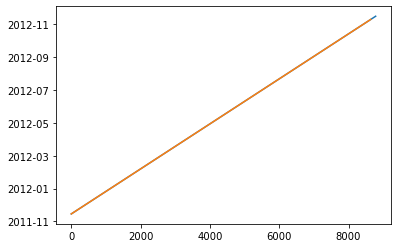

In [28]:
plt.plot(time_E)
plt.plot(np.unique(time_L))



### Low pass

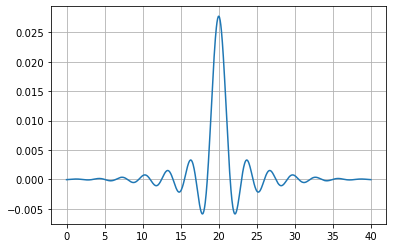

In [23]:
dt = 1. # in hours
Tw = 40
omega = 1/72
h = signal.firwin(Tw*24, cutoff=[omega], pass_zero=True, nyq=1./2/dt, scale=True)

ax = plt.subplot(111)
ax.plot(np.arange(0,Tw,dt/24),h)
ax.grid()

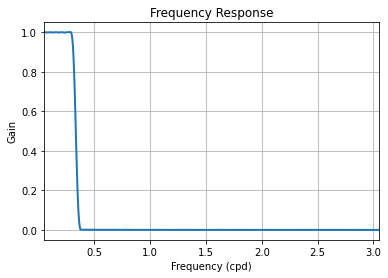

In [24]:
w, hh = signal.freqz(h, worN=8000)
plt.plot((w/np.pi)/2/dt*24, abs(hh), linewidth=2)
plt.xlabel('Frequency (cpd)')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.ylim(-0.05, 1.05)
plt.xlim(0.05, 3.05)
plt.grid(True)

In [25]:
V = ['zonal_velocity','meridional_velocity','Eta']
ds_low = xr.merge([filt(dsp[v], h,hilbert=False).rename(v+'_hat') for v in V]).persist()

In [26]:
for v in V:
    ds_low[v+'_hat'] = ds_low[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})



### Plot for a time interval of 60 days (mid time series) : 
1)2 drifters + demodulated Eulerian (+ corresponding time series?)

2)low pass + 2-3 drifters

In [34]:
dt = 1/24
t_mid = int(366/dt//2)
dtime = int(5/dt)

In [35]:
t_mid-dtime

4272

In [36]:
dsi = ds_hat.isel(time=slice(int(t_mid-dtime),int(t_mid+dtime)))
dfi = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000248].compute()
dfi_2 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000097].compute()

In [37]:
print(dsi.time.values.size,dfi.index.size)

240 240


In [38]:
dfi = dfi.reset_index().drop_duplicates(subset='time').set_index('time')
dfi_2 = dfi_2.reset_index().drop_duplicates(subset='time').set_index('time')

In [39]:
print(dsi.time.values.size,dfi.index.size)

240 240


In [40]:
[dfi.index[i]-dsi.time.values[i] for i in range(dfi.index.size)][0]==np.timedelta64(0,'D')

True

In [41]:
time = dfi.index

In [42]:
df_mid = dfi.loc[time[time.size//2]]
df_mid_2 = dfi_2.loc[time[time.size//2]]

In [43]:
eps = 0.01
ds_mid = dsi.zonal_velocity_demodulated_real.where((dsi.lon<=df_mid.lon+eps)&(dsi.lon>=df_mid.lon-eps)&
                                                   (dsi.lat<=df_mid.lat+eps)&(dsi.lat>=df_mid.lat-eps),drop=True)#.sel(time=time[time.size//2])
ds_mid_2 = dsi.zonal_velocity_demodulated_real.where((dsi.lon<=df_mid_2.lon+eps)&(dsi.lon>=df_mid_2.lon-eps)&
                                                   (dsi.lat<=df_mid_2.lat+eps)&(dsi.lat>=df_mid_2.lat-eps),drop=True)#.sel(time=time[time.size//2])

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(-155.5, -154.5)

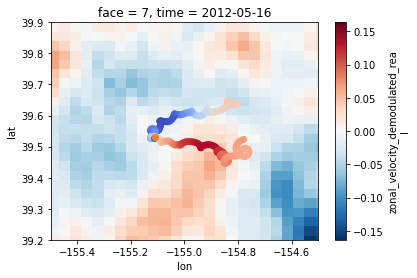

In [44]:
dsi.zonal_velocity_demodulated_real.sel(time=time[time.size//2]).plot(x='lon',y='lat')
plt.scatter(dfi.lon,dfi.lat,c=np.real(dfi.zonal_velocity_demodulated),cmap='coolwarm')
plt.scatter(ds_mid.lon,ds_mid.lat)
plt.scatter(df_mid.lon,df_mid.lat);plt.ylim(39.2,39.9);plt.xlim(-155.5,-154.5)

(-157.5, -156.5)

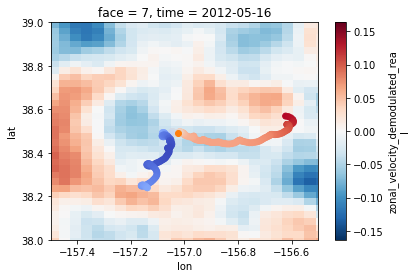

In [42]:
dsi.zonal_velocity_demodulated_real.sel(time=time[time.size//2]).plot(x='lon',y='lat')
plt.scatter(dfi_2.lon,dfi_2.lat,c=np.real(dfi.zonal_velocity_demodulated),cmap='coolwarm')
plt.scatter(ds_mid_2.lon,ds_mid_2.lat)
plt.scatter(df_mid_2.lon,df_mid_2.lat);plt.ylim(38.,39.);plt.xlim(-157.5,-156.5)

In [43]:
v = 'zonal_velocity_demodulated_real'
idw_eta, neighbors = [],[]
idw_eta_mid, neighbors_mid = [],[]
for it in range(time.size):
    mesh = pyinterp.RTree()
    _dsi = dsi.sel(time=dfi.index.values[it],method='nearest')
    mesh.packing(np.vstack((_dsi.XC.values.flatten(), 
                            _dsi.YC.values.flatten())).T,
                     np.real(_dsi[v].values).flatten(),
                    )

    idw_eta.append(mesh.inverse_distance_weighting(
            np.vstack((dfi.lon[it], dfi.lat[it])).T,
            within=True,
            radius=5e5,
            k=4,  
            num_threads=0)[0])
    neighbors.append(mesh.inverse_distance_weighting(
            np.vstack((dfi.lon[it], dfi.lat[it])).T,
            within=True,
            radius=5e5,
            k=4,  
            num_threads=0)[1])
    idw_eta_mid.append(mesh.inverse_distance_weighting(
            np.vstack((np.real(dfi.lon[time.size//2]), np.real(dfi.lat[time.size//2]))).T,
            within=True,
            radius=5e5,
            k=4,  
            num_threads=0)[0])
    neighbors_mid.append(mesh.inverse_distance_weighting(
            np.vstack((np.real(dfi.lon[time.size//2]), np.real(dfi.lat[time.size//2]))).T,
            within=True,
            radius=5e5,
            k=4,  
            num_threads=0)[1])
    #df_sub[v+'_interp'] = idw_eta 

In [44]:
v = 'zonal_velocity_demodulated_real'
idw_eta2, neighbors2 = [],[]
idw_eta_mid2, neighbors_mid2 = [],[]
for it in range(time.size):
    mesh = pyinterp.RTree()
    _dsi = dsi.sel(time=dfi_2.index.values[it],method='nearest')
    mesh.packing(np.vstack((_dsi.XC.values.flatten(), 
                            _dsi.YC.values.flatten())).T,
                     np.real(_dsi[v].values).flatten(),
                    )

    idw_eta2.append(mesh.inverse_distance_weighting(
            np.vstack((dfi_2.lon[it], dfi_2.lat[it])).T,
            within=True,
            radius=5e5,
            k=4,  
            num_threads=0)[0])
    neighbors2.append(mesh.inverse_distance_weighting(
            np.vstack((dfi_2.lon[it], dfi_2.lat[it])).T,
            within=True,
            radius=5e5,
            k=4,  
            num_threads=0)[1])
    idw_eta_mid2.append(mesh.inverse_distance_weighting(
            np.vstack((np.real(dfi_2.lon[time.size//2]), np.real(dfi_2.lat[time.size//2]))).T,
            within=True,
            radius=5e5,
            k=4,  
            num_threads=0)[0])
    neighbors_mid2.append(mesh.inverse_distance_weighting(
            np.vstack((np.real(dfi_2.lon[time.size//2]), np.real(dfi_2.lat[time.size//2]))).T,
            within=True,
            radius=5e5,
            k=4,  
            num_threads=0)[1])
    #df_sub[v+'_interp'] = idw_eta 

In [125]:
v = 'zonal_velocity_demodulated_imag'
idw_eta_i, neighbors_i = [],[]
idw_eta_mid_i, neighbors_mid_i = [],[]
for it in range(time.size):
    mesh = pyinterp.RTree()
    _dsi = dsi.sel(time=dfi.index.values[it],method='nearest')
    mesh.packing(np.vstack((_dsi.XC.values.flatten(), 
                            _dsi.YC.values.flatten())).T,
                     np.real(_dsi[v].values).flatten(),
                    )

    idw_eta_i.append(mesh.inverse_distance_weighting(
            np.vstack((dfi.lon[it], dfi.lat[it])).T,
            within=True,
            radius=5e5,
            k=8,  
            num_threads=0)[0])
    neighbors_i.append(mesh.inverse_distance_weighting(
            np.vstack((dfi.lon[it], dfi.lat[it])).T,
            within=True,
            radius=5e5,
            k=8,  
            num_threads=0)[1])
    idw_eta_mid_i.append(mesh.inverse_distance_weighting(
            np.vstack((np.real(dfi.lon[time.size//2]), np.real(dfi.lat[time.size//2]))).T,
            within=True,
            radius=5e5,
            k=8,  
            num_threads=0)[0])
    neighbors_mid_i.append(mesh.inverse_distance_weighting(
            np.vstack((np.real(dfi.lon[time.size//2]), np.real(dfi.lat[time.size//2]))).T,
            within=True,
            radius=5e5,
            k=8,  
            num_threads=0)[1])
    #df_sub[v+'_interp'] = idw_eta 

In [126]:
v = 'zonal_velocity_hat'
idw_eta_hat, neighbors_hat = [],[]
for it in range(time.size):
    mesh = pyinterp.RTree()
    _dsi = dsi.sel(time=dfi.index.values[it],method='nearest')
    mesh.packing(np.vstack((_dsi.XC.values.flatten(), 
                            _dsi.YC.values.flatten())).T,
                     np.real(_dsi[v].values).flatten(),
                    )

    idw_eta_hat.append(mesh.inverse_distance_weighting(
            np.vstack((dfi.lon[it], dfi.lat[it])).T,
            within=True,
            radius=5e5,
            k=8,  
            num_threads=0)[0])
    neighbors_hat.append(mesh.inverse_distance_weighting(
            np.vstack((dfi.lon[it], dfi.lat[it])).T,
            within=True,
            radius=5e5,
            k=8,  
            num_threads=0)[1])
    #df_sub[v+'_interp'] = idw_eta 

In [128]:
interp_hat_real = idw_eta_hat[0]
for i in idw_eta_hat[1:]:
    interp_hat_real = np.insert(interp_hat_real,-1,i)

In [45]:
interp_demod_real_traj = idw_eta[0]
for i in idw_eta[1:]:
    interp_demod_real_traj = np.insert(interp_demod_real_traj,-1,i)
interp_demod_real_mid = idw_eta_mid[0]
for i in idw_eta_mid[1:]:
    interp_demod_real_mid = np.insert(interp_demod_real_mid,-1,i)
#interp_demod_real_mid_i = idw_eta_mid_i[0]
#for i in idw_eta_mid_i[1:]:
#    interp_demod_real_mid_i = np.insert(interp_demod_real_mid_i,-1,i)
#interp_demod_real_traj_i = idw_eta_i[0]
#for i in idw_eta_i[1:]:
#    interp_demod_real_traj_i = np.insert(interp_demod_real_traj_i,-1,i)

In [47]:
interp_demod_real_traj2 = idw_eta2[0]
for i in idw_eta2[1:]:
    interp_demod_real_traj2 = np.insert(interp_demod_real_traj2,-1,i)
interp_demod_real_mid2 = idw_eta_mid2[0]
for i in idw_eta_mid2[1:]:
    interp_demod_real_mid2 = np.insert(interp_demod_real_mid2,-1,i)

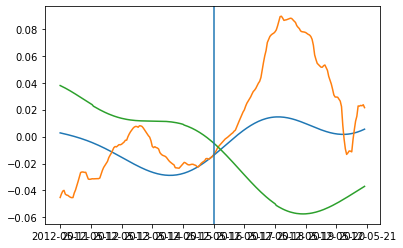

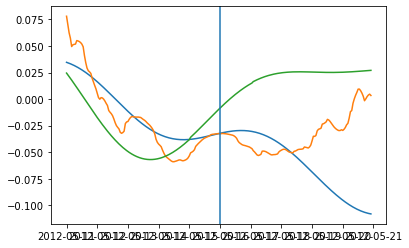

In [52]:
# 4 neighbors
plt.plot(time[:-1],interp_demod_real_mid[:-1])
plt.plot(time[:-1],interp_demod_real_traj[:-1])
plt.plot(time[:-1],np.real(dfi.zonal_velocity_demodulated)[:-1])
#plt.plot(time,np.imag(dfi.zonal_velocity_demodulated))
plt.axvline(time[time.size//2])

plt.figure()
plt.plot(time[:-1],interp_demod_real_mid2[:-1])
plt.plot(time[:-1],interp_demod_real_traj2[:-1])
plt.plot(time[:-1],np.real(dfi_2.zonal_velocity_demodulated)[:-1])
#plt.plot(time,np.imag(dfi.zonal_velocity_demodulated))
plt.axvline(time[time.size//2])

NameError: name 'interp_demod_real_mid_i' is not defined

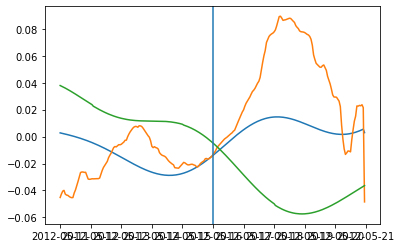

<Figure size 432x288 with 0 Axes>

In [51]:
#8 neighbors
#plt.plot(time,interp_hat_real)
#plt.plot(time,np.real(dfi.zonal_velocity_hat))

plt.plot(time,interp_demod_real_mid)
plt.plot(time,interp_demod_real_traj)
plt.plot(time,np.real(dfi.zonal_velocity_demodulated))
#plt.plot(time,np.imag(dfi.zonal_velocity_demodulated))
plt.axvline(time[time.size//2])

plt.figure()
plt.plot(time[:-1],interp_demod_real_mid_i[:-1])
plt.plot(time[:-1],interp_demod_real_traj_i[:-1])
plt.plot(time[:-1],np.imag(dfi.zonal_velocity_demodulated)[:-1])
#plt.plot(time,np.imag(dfi.zonal_velocity_demodulated))
plt.axvline(time[time.size//2])

-0.012648099421415532 -0.013433688055246227


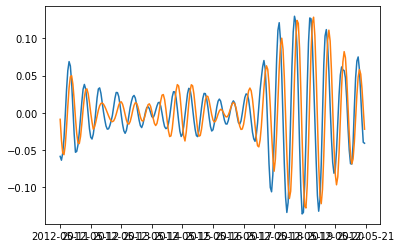

In [134]:
print(interp_demod_real_traj[time.size//2],interp_demod_real_mid[time.size//2])
plt.plot(time,interp_hat_real)
plt.plot(time,np.real(dfi.zonal_velocity_hat))

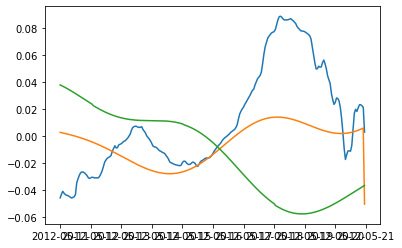

In [67]:
plt.plot(time,interp_demod_real_traj)
plt.plot(time,interp_demod_real_mid)
plt.plot(time,np.real(dfi.zonal_velocity_demodulated))

In [283]:
_ = ds_hat.isel(time=slice(int(t_mid-dtime),int(t_mid+dtime))).where((dsi.lon>=loni-eps)&(dsi.lon<=loni+eps)&(dsi.lat>=lati-eps)&(dsi.lat<=lati+eps),drop=True)
_ = ds_hat.isel(time=slice(int(t_mid-dtime),int(t_mid+dtime))).where((dsi.lon>=loni-eps)&(dsi.lon<=loni+eps)&(dsi.lat>=lati-eps)&(dsi.lat<=lati+eps),drop=True)
_2 = ds_hat.isel(time=slice(int(t_mid-2*dtime),int(t_mid+2*dtime))).where((dsi.lon>=loni-eps)&(dsi.lon<=loni+eps)&(dsi.lat>=lati-eps)&(dsi.lat<=lati+eps),drop=True)

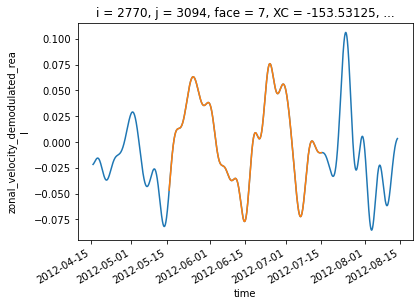

In [285]:
_2.zonal_velocity_demodulated_real.plot()
_.zonal_velocity_demodulated_real.plot()

In [255]:
time_L = df_filtered.index.values.compute()
time_E = ds_hat.time.values

In [256]:
_f =  df_filtered[df_filtered.trajectory==38000248].compute().reset_index().sort_values('time').set_index('time')
#_f2 =  dfi[dfi.trajectory==38000248].compute().reset_index().sort_values('time').set_index('time')


In [229]:
print(_f2.index[0],dsi.time.values[0])
print(_f2.index[-1],dsi.time.values[-1])

NameError: name '_f2' is not defined

In [257]:
dsi = ds_hat.isel(time=slice(int(t_mid-dtime),int(t_mid+dtime))).persist()
dsi_low = ds_low.isel(time=slice(int(t_mid-dtime),int(t_mid+dtime))).persist()
#eps=0.01
#_dsi = dsi.where((dsi.lon>=loni-eps)&(dsi.lon<=loni+eps)&(dsi.lat>=lati-eps)&(dsi.lat<=lati+eps),drop=True)

In [258]:
time_size = dsi.zonal_velocity_demodulated.shape[-1]
t_mid_2 = dsi.isel(time=time_size//2).time.values

In [259]:
_df2 = _f.loc[dsi.time.values]
loni,lati = _df2.loc[t_mid_2].lon,_df2.loc[t_mid_2].lat

eps=0.015
_dsi = dsi.where((dsi.lon>=loni-eps)&(dsi.lon<=loni+eps)&(dsi.lat>=lati-eps)&(dsi.lat<=lati+eps),drop=True)

In [193]:
_dsi

<xarray.Dataset>
Dimensions:                               (i: 0, j: 0, time: 1440)
Coordinates:
  * i                                     (i) int64 
  * j                                     (j) int64 
    face                                  int64 7
  * time                                  (time) datetime64[ns] 2011-12-15 .....
    XC                                    (j, i) float32 dask.array<chunksize=(0, 0), meta=np.ndarray>
    YC                                    (j, i) float32 dask.array<chunksize=(0, 0), meta=np.ndarray>
    Depth                                 (j, i) float32 dask.array<chunksize=(0, 0), meta=np.ndarray>
    CS                                    (j, i) float32 dask.array<chunksize=(0, 0), meta=np.ndarray>
    SN                                    (j, i) float32 dask.array<chunksize=(0, 0), meta=np.ndarray>
    rA                                    (j, i) float32 dask.array<chunksize=(0, 0), meta=np.ndarray>
    lon                                   (j, i) float64 dask.array<chunksize=(0, 0), meta=np.ndarray>
    lat                                   (j, i) float64 dask.array<chunksize=(0, 0), meta=np.ndarray>
Data variables:
    zonal_velocity_hat                    (j, i, time) complex128 dask.array<chunksize=(0, 0, 1440), meta=np.ndarray>
    zonal_velocity_demodulated            (j, i, time) complex128 dask.array<chunksize=(0, 0, 1440), meta=np.ndarray>
    zonal_velocity_demodulated_real       (j, i, time) float64 dask.array<chunksize=(0, 0, 1440), meta=np.ndarray>
    zonal_velocity_demodulated_imag       (j, i, time) float64 dask.array<chunksize=(0, 0, 1440), meta=np.ndarray>
    meridional_velocity_hat               (j, i, time) complex128 dask.array<chunksize=(0, 0, 1440), meta=np.ndarray>
    meridional_velocity_demodulated       (j, i, time) complex128 dask.array<chunksize=(0, 0, 1440), meta=np.ndarray>
    meridional_velocity_demodulated_real  (j, i, time) float64 dask.array<chunksize=(0, 0, 1440), meta=np.ndarray>
    meridional_velocity_demodulated_imag  (j, i, time) float64 dask.array<chunksize=(0, 0, 1440), meta=np.ndarray>
    Eta_hat                               (j, i, time) complex128 dask.array<chunksize=(0, 0, 1440), meta=np.ndarray>
    Eta_demodulated                       (j, i, time) complex128 dask.array<chunksize=(0, 0, 1440), meta=np.ndarray>
    Eta_demodulated_real                  (j, i, time) float64 dask.array<chunksize=(0, 0, 1440), meta=np.ndarray>
    Eta_demodulated_imag                  (j, i, time) float64 dask.array<chunksize=(0, 0, 1440), meta=np.ndarray>

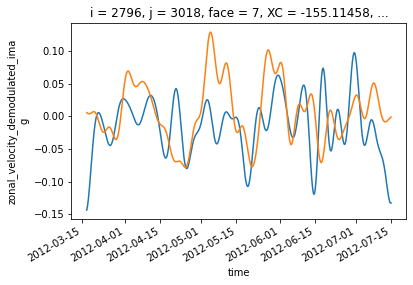

In [82]:
#_f.loc[dsi.time.values].zonal_velocity_demodulated.plot()
#_f.loc[dsi.time.values].zonal_velocity_demodulated.apply(lambda x : np.real(x)).plot()
_f.loc[dsi.time.values].zonal_velocity_demodulated.apply(lambda x : np.imag(x)).plot()
_dsi.zonal_velocity_demodulated_imag.plot()

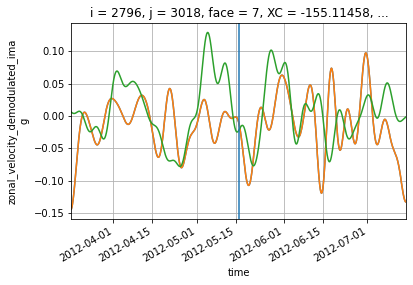

In [116]:
_f.zonal_velocity_demodulated.apply(lambda x : np.imag(x)).plot()
plt.plot(dsi.time.values,np.imag(_df2.zonal_velocity_demodulated))
ds_hat.zonal_velocity_demodulated_imag.where((dsi.lon>=loni-eps)&(dsi.lon<=loni+eps)&(dsi.lat>=lati-eps)&(dsi.lat<=lati+eps),drop=True).plot()
plt.xlim(dsi.time.values[0],dsi.time.values[-1])
plt.grid();plt.axvline(dsi.time.values[2880//2])

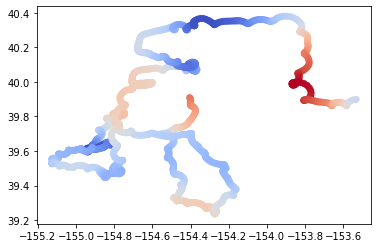

In [130]:
plt.scatter(_df2.lon,_df2.lat,c=np.real(_df2.zonal_velocity_demodulated),cmap='coolwarm')

In [128]:
_df2 = _df2.drop_duplicates()

In [129]:
_df2 = _df2.reset_index().drop_duplicates('time').set_index('time')

In [111]:
print(dsi.time.values.size,_df2.index.size)
print(dsi.time.values[0],_df2.index[0])
print(dsi.time.values[-1],_df2.index[-1])

2880 2880
2012-03-17T00:00:00.000000000 2012-03-17 00:00:00
2012-07-14T23:00:00.000000000 2012-07-14 23:00:00


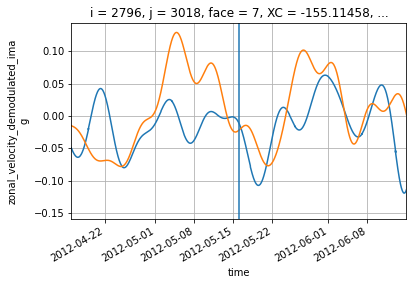

In [52]:
_f.zonal_velocity_demodulated.apply(lambda x : np.imag(x)).plot()
ds_hat.zonal_velocity_demodulated_imag.where((dsi.lon>=loni-eps)&(dsi.lon<=loni+eps)&(dsi.lat>=lati-eps)&(dsi.lat<=lati+eps),drop=True).plot()
plt.xlim(dsi.time.values[0],dsi.time.values[-1])
plt.grid();plt.axvline(dsi.time.values[722])

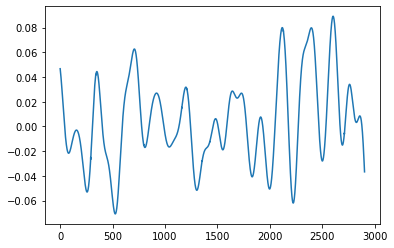

In [92]:
plt.plot(np.real(_df2.zonal_velocity_demodulated))

In [260]:
dfi = df_filtered.loc[dsi.time.values].persist()

In [261]:
tim = np.unique(dfi.index.values.compute())

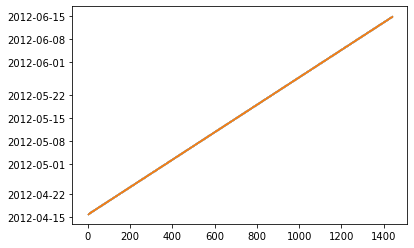

In [37]:
plt.scatter(np.arange(0,tim.size),dsi.time.values,s=0.1)
plt.scatter(np.arange(0,tim.size),tim,s=0.1)


In [262]:
lonmin,lonmax,latmin,latmax = dsi.lon.min().values,dsi.lon.max().values,dsi.lat.min().values,dsi.lat.max().values
# extract relevant trajectory indices
bbox=[lonmin,lonmax,latmin,latmax]
_dfi = dfi[ (dfi.lon>=bbox[0])
        &(dfi.lon<=bbox[1])
        &(dfi.lat>=bbox[2])
        &(dfi.lat<=bbox[3])
       ]
traj = _dfi.drop_duplicates(subset=["trajectory"]).compute()["trajectory"]

In [263]:
_dfi = dfi[dfi.trajectory.isin(traj)]

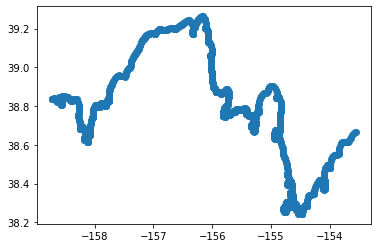

In [41]:
plt.scatter(_dfi[_dfi.trajectory==37000174].lon.compute(),_dfi[_dfi.trajectory==37000174].lat.compute())

In [196]:
_df2 = _df2.reset_index().drop_duplicates('time').set_index('time')
_ = _df2.apply(interp_trajectories,ds_hat,'zonal_velocity_demodulated_real')

TypeError: unhashable type: 'Dataset'

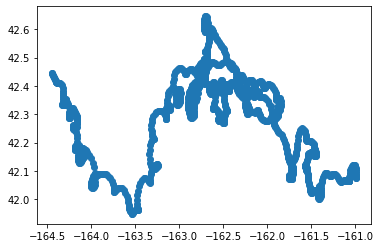

In [198]:
plt.scatter(_df2.lon,_df2.lat)

In [199]:

v = 'zonal_velocity_demodulated_real'
dfi_interp = _dfi.groupby(_dfi.index).apply(interp_trajectories,dsi,v).persist()
V = ['zonal_velocity_demodulated_imag','meridional_velocity_demodulated_real','meridional_velocity_demodulated_imag']
for v in V:
    dfi_interp = dfi_interp.groupby(dfi_interp.index).apply(interp_trajectories,dsi,v).persist()
    #dfi_interp = _dfi.groupby(_dfi.index).apply(interp_trajectories,dsi,v+'_imag').persist()


<ipython-input-199-200be8da4971>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  dfi_interp = _dfi.groupby(_dfi.index).apply(interp_trajectories,dsi,v).persist()
<ipython-input-199-200be8da4971>:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  dfi_interp = dfi_interp.groupby(dfi_interp.index).apply(interp_trajectories,dsi,v).persist()


In [264]:
dfi_interp = _dfi
_df1 = dfi_interp[dfi_interp.trajectory==37000174].compute().reset_index().sort_values('time').set_index('time')
_df2 = dfi_interp[dfi_interp.trajectory==38000248].compute().reset_index().sort_values('time').set_index('time')
_df3 = dfi_interp[dfi_interp.trajectory==38001401].compute().reset_index().sort_values('time').set_index('time')#38001263
_df4 = dfi_interp[dfi_interp.trajectory==38000024].compute().reset_index().sort_values('time').set_index('time')#38001401
_df5 = dfi_interp[dfi_interp.trajectory==38000172].compute().reset_index().sort_values('time').set_index('time')
_df6 = dfi_interp[dfi_interp.trajectory==38000097].compute().reset_index().sort_values('time').set_index('time')

In [265]:
for _df in [_df1,_df2,_df3,_df4,_df5,_df6]:
    _df = _df.reset_index().drop_duplicates('time').sort_values('time').set_index('time')

IndexError: index 6 is out of bounds for axis 0 with size 0

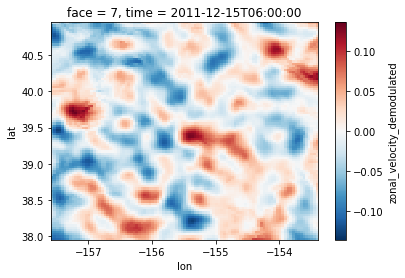

In [219]:
fig,ax= plt.subplots()
dsi.zonal_velocity_demodulated.real.isel(time=6).plot(ax=ax,x='lon',y='lat')
for _df in [_df1,_df2,_df3,_df4]:
    ax.scatter(_df.lon,_df.lat,c='k',s=3)
    ax.scatter(_df.lon[6],_df.lat[6],c='r',s=4)
ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax);

In [266]:
time_size = dsi.zonal_velocity_demodulated.shape[-1]
t_mid_2 = dsi.isel(time=time_size//2).time.values

In [240]:
_dfi

Dask DataFrame Structure:
                    trajectory      lat      lon        z zonal_velocity meridional_velocity sea_level temperature salinity zonal_velocity_hat meridional_velocity_hat zonal_velocity_demodulated meridional_velocity_demodulated
npartitions=2                                                                                                                                                                                                                    
2012-04-16 00:00:00      int64  float64  float64  float64        float64             float32   float32     float32  float32         complex128              complex128                 complex128                      complex128
2012-05-18 16:00:00        ...      ...      ...      ...            ...                 ...       ...         ...      ...                ...                     ...                        ...                             ...
2012-06-14 23:00:00        ...      ...      ...      ...            ...                 ...       ...         ...      ...                ...                     ...                        ...                             ...
Dask Name: getitem, 9 tasks

In [269]:
loni,lati = _df2.loc[t_mid_2].lon,_df2.loc[t_mid_2].lat

eps=0.015
_dsi = dsi.where((dsi.lon>=loni-eps)&(dsi.lon<=loni+eps)&(dsi.lat>=lati-eps)&(dsi.lat<=lati+eps),drop=True)

In [270]:
_dsi

<xarray.Dataset>
Dimensions:                               (i: 1, j: 1, time: 1440)
Coordinates:
  * i                                     (i) int64 2770
  * j                                     (j) int64 3094
    face                                  int64 7
  * time                                  (time) datetime64[ns] 2012-05-16 .....
    XC                                    (j, i) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    YC                                    (j, i) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    Depth                                 (j, i) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    CS                                    (j, i) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SN                                    (j, i) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    rA                                    (j, i) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon                                   (j, i) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lat                                   (j, i) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
Data variables:
    zonal_velocity_hat                    (j, i, time) complex128 dask.array<chunksize=(1, 1, 1440), meta=np.ndarray>
    zonal_velocity_demodulated            (j, i, time) complex128 dask.array<chunksize=(1, 1, 1440), meta=np.ndarray>
    zonal_velocity_demodulated_real       (j, i, time) float64 dask.array<chunksize=(1, 1, 1440), meta=np.ndarray>
    zonal_velocity_demodulated_imag       (j, i, time) float64 dask.array<chunksize=(1, 1, 1440), meta=np.ndarray>
    meridional_velocity_hat               (j, i, time) complex128 dask.array<chunksize=(1, 1, 1440), meta=np.ndarray>
    meridional_velocity_demodulated       (j, i, time) complex128 dask.array<chunksize=(1, 1, 1440), meta=np.ndarray>
    meridional_velocity_demodulated_real  (j, i, time) float64 dask.array<chunksize=(1, 1, 1440), meta=np.ndarray>
    meridional_velocity_demodulated_imag  (j, i, time) float64 dask.array<chunksize=(1, 1, 1440), meta=np.ndarray>
    Eta_hat                               (j, i, time) complex128 dask.array<chunksize=(1, 1, 1440), meta=np.ndarray>
    Eta_demodulated                       (j, i, time) complex128 dask.array<chunksize=(1, 1, 1440), meta=np.ndarray>
    Eta_demodulated_real                  (j, i, time) float64 dask.array<chunksize=(1, 1, 1440), meta=np.ndarray>
    Eta_demodulated_imag                  (j, i, time) float64 dask.array<chunksize=(1, 1, 1440), meta=np.ndarray>

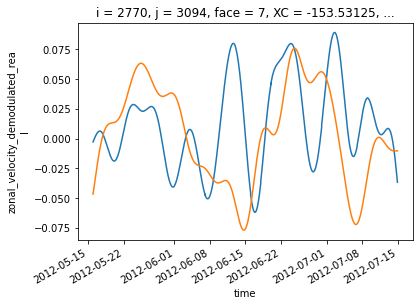

In [271]:
plt.plot(_df2.zonal_velocity_demodulated.apply(lambda x: np.real(x)))
#plt.plot(_f2.zonal_velocity_demodulated.apply(lambda x: np.real(x)))
_dsi.zonal_velocity_demodulated_real.plot()

(38.2, 39.3)

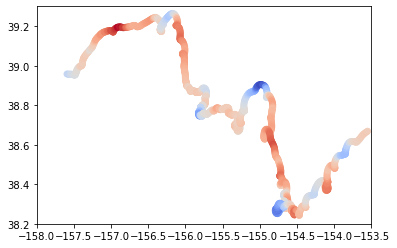

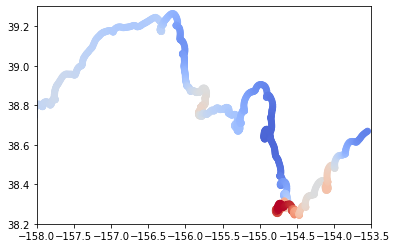

In [172]:
plt.scatter(_df1.lon,_df1.lat,c=_df1.zonal_velocity_demodulated_real_interp,cmap='coolwarm')
plt.xlim(-158,-153.5);plt.ylim(38.2,39.3)
plt.figure()
plt.scatter(_df1.lon,_df1.lat,c=_df1.zonal_velocity_demodulated.apply(lambda x: np.real(x)),cmap='coolwarm')
plt.xlim(-158,-153.5);plt.ylim(38.2,39.3)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


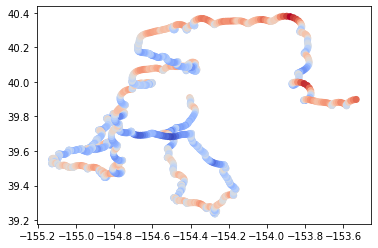

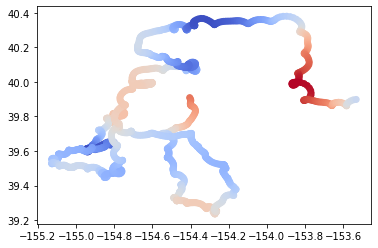

In [247]:
plt.scatter(_df2.lon,_df2.lat,c=_df2.zonal_velocity,cmap='coolwarm')
plt.figure()
plt.scatter(_df2.lon,_df2.lat,c=_df2.zonal_velocity_demodulated,cmap='coolwarm')

In [248]:
_df.index.size

1440

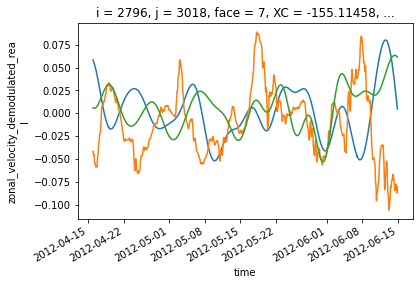

In [151]:
_df2.zonal_velocity_demodulated.apply(lambda x : np.real(x)).plot()
_df2.zonal_velocity_demodulated_real_interp.plot()
_dsi.zonal_velocity_demodulated_real.plot()

<AxesSubplot:xlabel='time'>

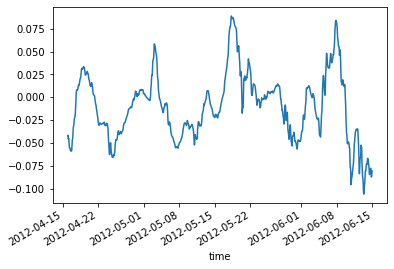

In [152]:
_df2.zonal_velocity_demodulated_real_interp.plot()

In [272]:
_df = [_df1,_df2,_df3,_df4,_df5,_df6]
def gen_figs_flts(_df,it,v,dt,savefig=False):
    name=v+'_%s'%it
    _s = dsi.isel(time=it)
    t = _s.time.values
    fig,axs= plt.subplots(2,2,figsize=(10,10))
#    fig = plt.figure(figsize=(10,10),constrained_layout=True)
#    gs = gridspec.GridSpec(2, 2, figure=fig)
#    ax = fig.add_subplot(gs[0, 0],sharey=True)
    ax= axs[0,0]
    _s[v+'_demodulated'].real.plot(ax=ax,x='lon',y='lat',vmax=0.2,add_colorbar=False)
                                                  #,cbar_kwargs={'label':'Demodulated '+v+' : real part'})
    if it>= 3/dt:
        t0 = t-np.timedelta64(3,'D')
    else:
        t0= dsi.isel(time=0).time.values
    #ax.scatter(_df[1].lon,_df[1].lat,c='grey',marker='.',s=1,alpha=0.3)    
    ax.scatter(_df[1].loc[t0:t].lon,_df[1].loc[t0:t].lat,c='darkred',s=3)    
    for _f in [_df1,_df3,_df4,_df5,_df6]:
        ax.scatter(_f.loc[t0:t].lon,_f.loc[t0:t].lat,marker='.',c='k',s=3)    
    for _f in _df:
        ax.scatter(_f.lon,_f.lat,c='grey',marker='.',s=1,alpha=0.1)    
        ax.scatter(_f.loc[t].lon,_f.loc[t].lat,c='r',s=10)
    ax.scatter(_dsi[v+'_demodulated'].lon.values,_dsi[v+'_demodulated'].lat.values,c='lightseagreen',marker='d')
    ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax);
    ax.set_title('Demodulated '+v+' : real part');#ax.set_aspect('equal');
    ax=axs[0,1]
    cs = _s[v+'_demodulated'].imag.plot(ax=ax,x='lon',y='lat',vmax=0.2,add_colorbar=False)
                                                 # ,cbar_kwargs={'label':'Demodulated velocity'})
    #ax.scatter(_df[1].lon,_df[1].lat,c='grey',marker='.',s=1,alpha=0.3)    
    ax.scatter(_df[1].loc[t0:t].lon,_df[1].loc[t0:t].lat,c='darkred',s=3)    
    for _f in [_df1,_df3,_df4,_df5,_df6]:
        ax.scatter(_f.loc[t0:t].lon,_f.loc[t0:t].lat,marker='.',c='k',s=3)    
    for _f in _df:
        ax.scatter(_f.lon,_f.lat,c='grey',marker='.',s=1,alpha=0.1)    
        ax.scatter(_f.loc[t].lon,_f.loc[t].lat,c='r',s=10)
    ax.scatter(_dsi[v+'_demodulated'].lon.values,_dsi[v+'_demodulated'].lat.values,c='lightseagreen',marker='d')
    ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax);
    ax.set_title('Demodulated '+v+' : imaginary part');#ax.set_aspect('equal')
    ax= axs[1,0]
    #_df[1][v+'_demodulated_interp'].apply(lambda x: np.real(x)).plot(ax=ax,c='grey',linestyle='--',linewidth=1)
    _df[1][v+'_demodulated'].apply(lambda x: np.real(x)).plot(ax=ax,c='firebrick');
    
    _dsi[v+'_demodulated'].real.plot(ax=ax,c='lightseagreen');
    ax.axvline(dsi.sel(time=t_mid_2).time.values,c='lightseagreen',linestyle='--',linewidth=1);
    ax.grid();ax.axvline(t,c='k');ax.set_ylabel('Velocity');ax.set_ylim(-0.15,0.15)
    #ax.set_title('Demodulated '+v+' : real part')
    ax= axs[1,1]
    #_df[1][v+'_demodulated_interp'].apply(lambda x: np.imag(x)).plot(ax=ax,c='k',linestyle='--',linewidth=1)
    _df[1][v+'_demodulated'].apply(lambda x: np.imag(x)).plot(ax=ax,c='firebrick')
    _dsi[v+'_demodulated'].imag.plot(ax=ax,c='lightseagreen')
    ax.axvline(dsi.sel(time=t_mid_2).time.values,c='lightseagreen',linestyle='--',linewidth=1);
    ax.grid();ax.axvline(t,c='k');
    ax.set_ylabel('');ax.set_ylim(-0.15,0.15)
    #ax.set_title('Demodulated '+v+' : imaginary part')
    for a in axs[1,:]:
        a.set_title('')
    fig.suptitle('Time : %s'%t.astype('M8[s]'))
    cax = plt.axes([1.01, .54, 0.02, 0.4])
#plt.colorbar(cax=cax)
    fig.colorbar(cs,cax=cax)
    fig.tight_layout()
    #print(_df2.index[it],dsi.isel(time=it).time.values)
    if savefig:
#        plt.show()
        fig.savefig('/home1/datawork/zcaspar/Figs/demodulated_flts/'+name+'.jpg')
        plt.close()

In [273]:
def gen_figs_flts_interp(_df,it,v,dt,savefig=False):
    name=v+'_%s'%it
    _s = dsi.isel(time=it)
    t = _s.time.values
    fig,axs= plt.subplots(2,2,figsize=(10,10))
#    fig = plt.figure(figsize=(10,10),constrained_layout=True)
#    gs = gridspec.GridSpec(2, 2, figure=fig)
#    ax = fig.add_subplot(gs[0, 0],sharey=True)
    ax= axs[0,0]
    _s[v+'_demodulated'].real.plot(ax=ax,x='lon',y='lat',vmax=0.2,add_colorbar=False)
                                                  #,cbar_kwargs={'label':'Demodulated '+v+' : real part'})
    if it>= 3/dt:
        t0 = t-np.timedelta64(3,'D')
    else:
        t0= dsi.isel(time=0).time.values
    #ax.scatter(_df[1].lon,_df[1].lat,c='grey',marker='.',s=1,alpha=0.3)    
    ax.scatter(_df[1].loc[t0:t].lon,_df[1].loc[t0:t].lat,c='darkred',s=3)    
    for _f in [_df1,_df3,_df4,_df5,_df6]:
        ax.scatter(_f.loc[t0:t].lon,_f.loc[t0:t].lat,marker='.',c='k',s=3)   
    for _f in _df:
        ax.scatter(_f.lon,_f.lat,c='grey',marker='.',s=1,alpha=0.1)    
        ax.scatter(_f.loc[t].lon,_f.loc[t].lat,c='r',s=10)
    ax.scatter(_dsi[v+'_demodulated'].lon.values,_dsi[v+'_demodulated'].lat.values,c='lightseagreen',marker='d')
    ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax);
    ax.set_title('Demodulated '+v+' : real part');#ax.set_aspect('equal');
    ax=axs[0,1]
    cs = dsi[v+'_demodulated'].imag.isel(time=it).plot(ax=ax,x='lon',y='lat',vmax=0.2,add_colorbar=False)
                                                 # ,cbar_kwargs={'label':'Demodulated velocity'})
    #ax.scatter(_df[1].lon,_df[1].lat,c='grey',marker='.',s=1,alpha=0.3)    
    ax.scatter(_df[1].loc[t0:t].lon,_df[1].loc[t0:t].lat,c='darkred',s=3)    
    for _f in [_df1,_df3,_df4,_df5,_df6]:
        ax.scatter(_f.loc[t0:t].lon,_f.loc[t0:t].lat,marker='.',c='k',s=3)    
    for _f in _df:
        ax.scatter(_f.lon,_f.lat,c='grey',marker='.',s=1,alpha=0.1)    
        ax.scatter(_f.loc[t].lon,_f.loc[t].lat,c='r',s=10)
    ax.scatter(_dsi[v+'_demodulated'].lon.values,_dsi[v+'_demodulated'].lat.values,c='lightseagreen',marker='d')
    ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax);
    ax.set_title('Demodulated '+v+' : imaginary part');#ax.set_aspect('equal')
    ax= axs[1,0]
    _df[1][v+'_demodulated_real_interp'].plot(ax=ax,c='grey',linestyle='--',linewidth=1)
    _df[1][v+'_demodulated'].apply(lambda x: np.real(x)).plot(ax=ax,c='firebrick');
    
    _dsi[v+'_demodulated'].real.plot(ax=ax,c='lightseagreen');
    ax.axvline(dsi.sel(time=t_mid_2).time.values,c='lightseagreen',linestyle='--',linewidth=1);
    ax.grid();ax.axvline(dsi.isel(time=it).time.values,c='k');ax.set_ylabel('Velocity');ax.set_ylim(-0.2,0.2)
    #ax.set_title('Demodulated '+v+' : real part')
    ax= axs[1,1]
    _df[1][v+'_demodulated_imag_interp'].plot(ax=ax,c='grey',linestyle='--',linewidth=1)
    _df[1][v+'_demodulated'].apply(lambda x: np.imag(x)).plot(ax=ax,c='firebrick')
    _dsi[v+'_demodulated'].imag.plot(ax=ax,c='lightseagreen')
    ax.axvline(dsi.sel(time=t_mid_2).time.values,c='lightseagreen',linestyle='--',linewidth=1);
    ax.grid();ax.axvline(t,c='k');
    ax.set_ylabel('');ax.set_ylim(-0.15,0.15)
    #ax.set_title('Demodulated '+v+' : imaginary part')
    for a in axs[1,:]:
        a.set_title('')
    fig.suptitle('Time : %s'%_s[v+'_demodulated'].time.values.astype('M8[s]'))
    cax = plt.axes([1.01, .54, 0.02, 0.4])
#plt.colorbar(cax=cax)
    fig.colorbar(cs,cax=cax)
    fig.tight_layout()
    if savefig:
#        plt.show()
        fig.savefig('/home1/datawork/zcaspar/Figs/demodulated_flts/'+name+'.jpg')
        plt.close()

In [274]:
_df = [_df1,_df2,_df3,_df4,_df5,_df6]
def gen_figs_flts_low(_df,it,v,dt,dij,s,savefig=False):
    name=v+'_%s'%it
    _low = dsi_low.isel(time=it,i=slice(0,None,dij),j=slice(0,None,dij))
    _s = dsi.isel(time=it)
    t = _s.time.values
    if it>= 1/dt:
        t0 = t-np.timedelta64(1,'D')
    else:
        t0=dsi.isel(time=0).time.values
    
    fig,axs= plt.subplots(1,2,figsize=(14,7))
    ax= axs[0]
    _s[v+'_demodulated'].real.plot(ax=ax,x='lon',y='lat',vmax=0.15,add_colorbar=True)
    #ax.plot(_df[1].lon[i0:it],_df[1].lat[i0:it],c='darkred')    
    #for _f in [_df1,_df3,_df4,_df5,_df6]:
    #    ax.plot(_f.lon[i0:it],_f.lat[i0:it],c='k')#,marker='.',c='k',s=3)    
    ax.quiver(_low.lon,_low.lat,_low['zonal_velocity_hat'],_low['meridional_velocity_hat'],scale=s,color='k')
    for _f in _df:
        ax.scatter(_f.loc[t].lon,_f.loc[t].lat,c='r',s=25,edgecolor='k')
    #ax.scatter(_dsi[v+'_demodulated'].lon.values,_dsi[v+'_demodulated'].lat.values,c='lightseagreen',marker='d')
       
    
    ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax);
    ax.set_title('Demodulated '+v+' : real part');
    ax=axs[1]
    cs = _s[v+'_demodulated'].imag.plot(ax=ax,x='lon',y='lat',vmax=0.15,add_colorbar=True)
    ax.quiver(_low.lon,_low.lat,_low['zonal_velocity_hat'],_low['meridional_velocity_hat'],scale=s)
    #ax.plot(_df[1].lon[i0:it],_df[1].lat[i0:it],c='darkred')    
    #for _f in [_df1,_df3,_df4,_df5,_df6]:
    #    ax.plot(_f.lon[i0:it],_f.lat[i0:it],c='k')#,marker='.',c='k',s=3)    
    for _f in _df:
        ax.scatter(_f.loc[t].lon,_f.loc[t].lat,c='r',s=25,edgecolor='k')
    #ax.scatter(_dsi[v+'_demodulated'].lon.values,_dsi[v+'_demodulated'].lat.values,c='lightseagreen',marker='d')
    
    ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax);
    ax.set_title('Demodulated '+v+' : imaginary part');
   # ax= axs[1,0]
   # _df[1][v+'_demodulated'].apply(lambda x: np.real(x)).plot(ax=ax,c='firebrick');
   # 
   # _dsi[v+'_demodulated'].real.plot(ax=ax,c='lightseagreen');
   # ax.axvline(dsi.sel(time=t_mid_2).time.values,c='lightseagreen',linestyle='--',linewidth=1);
   # ax.grid();ax.axvline(dsi.isel(time=it).time.values,c='k');ax.set_ylabel('Velocity');ax.set_ylim(-0.15,0.15)
   # ax= axs[1,1]
   # _df[1][v+'_demodulated'].apply(lambda x: np.imag(x)).plot(ax=ax,c='firebrick')
   # _dsi[v+'_demodulated'].imag.plot(ax=ax,c='lightseagreen')
   # ax.axvline(dsi.sel(time=t_mid_2).time.values,c='lightseagreen',linestyle='--',linewidth=1);
   # ax.grid();ax.axvline(dsi.isel(time=it).time.values,c='k');
   # ax.set_ylabel('');ax.set_ylim(-0.15,0.15)
   # for a in axs[1,:]:
   #     a.set_title('')
    fig.suptitle('Time : %s'%_s[v+'_demodulated'].time.values.astype('M8[s]'))
    #cax = plt.axes([1.01, .54, 0.02, 0.4])
    #fig.colorbar(cs,cax=cax)
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/demodulated_flts/'+name+'.jpg')
        plt.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplo

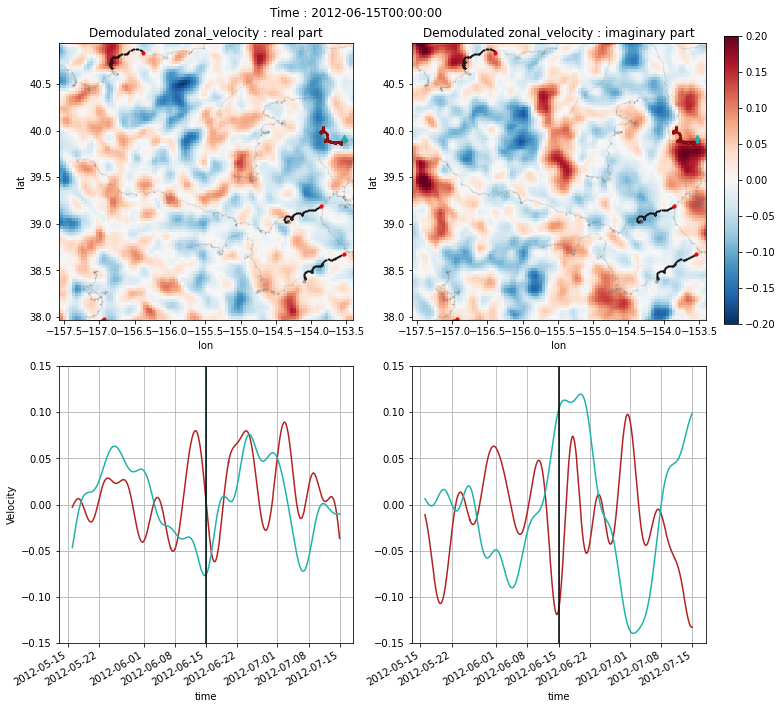

In [275]:
#import matplotlib.gridspec as gridspec

gen_figs_flts(_df,30*24,'zonal_velocity',1/24,savefig=False
             )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


KeyError: 'zonal_velocity_demodulated_real_interp'

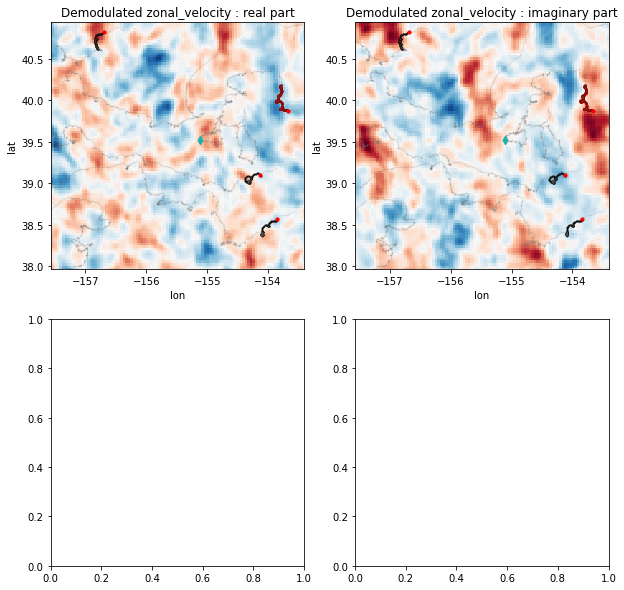

In [252]:
gen_figs_flts_interp(_df,59*24,'zonal_velocity',1/24,savefig=False
             )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


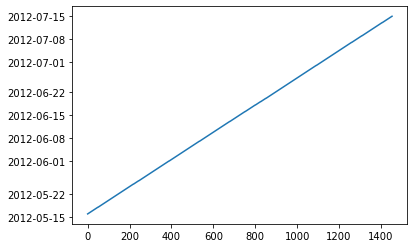

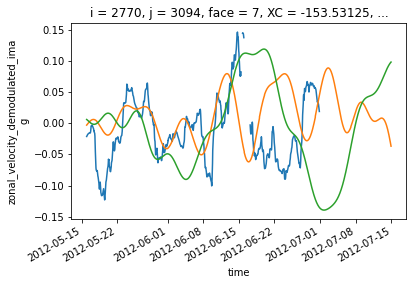

In [73]:
plt.plot(_df2.index.values)
plt.figure()
_df2.zonal_velocity_demodulated_imag_interp.plot()
_df2.zonal_velocity_demodulated.plot()
#_df2.zonal_velocity_demodulated_real_interp.plot()
_dsi.zonal_velocity_demodulated_imag.plot()

In [50]:
for v in ['zonal_velocity','meridional_velocity']:
    ds_low[v+'_hat'] = ds_low[v+'_hat'].mean('time')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croc

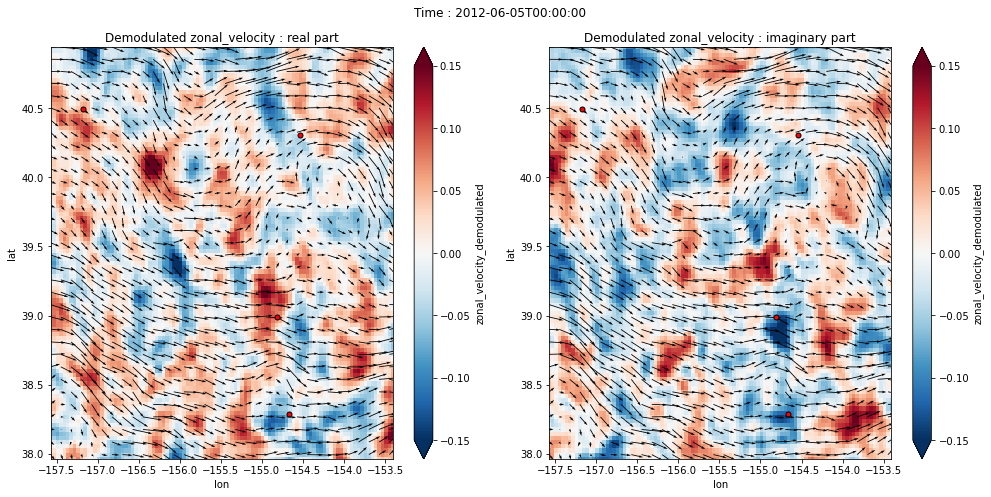

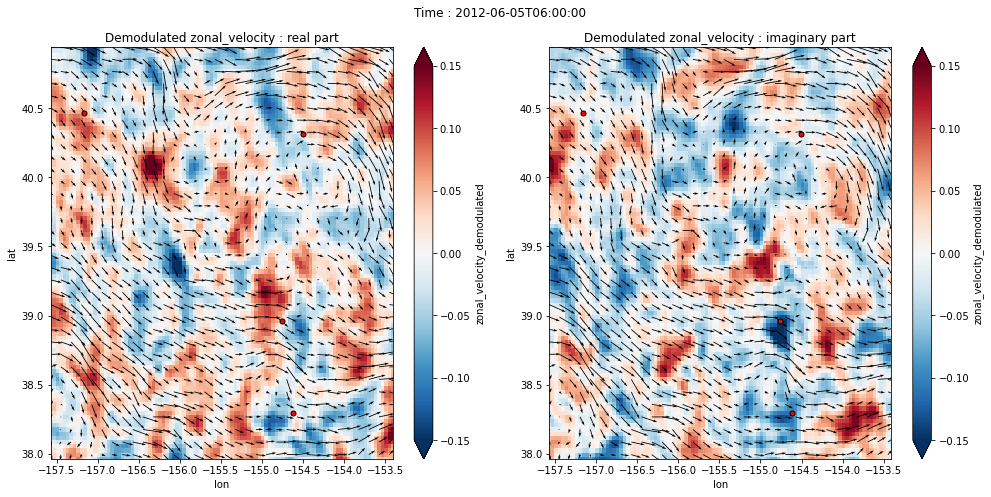

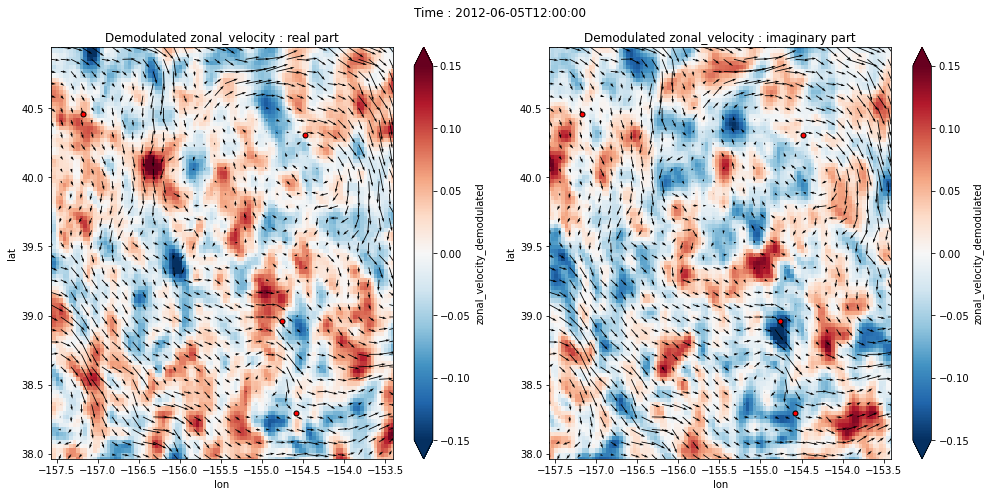

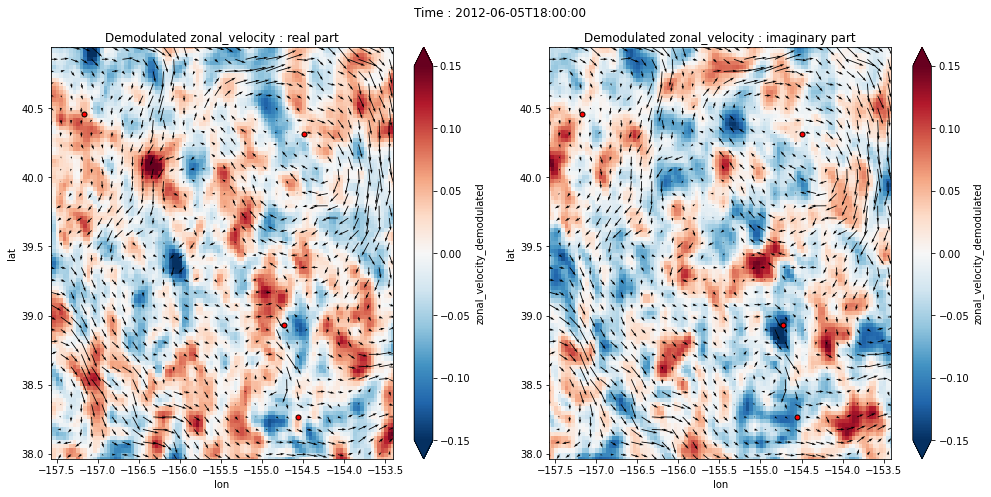

In [51]:
gen_figs_flts_low(_df,50*24,'zonal_velocity',1/24,3,5,savefig=False
             )
gen_figs_flts_low(_df,50*24+6,'zonal_velocity',1/24,3,5,savefig=False
             )
gen_figs_flts_low(_df,50*24+12,'zonal_velocity',1/24,3,5,savefig=False
             )
gen_figs_flts_low(_df,50*24+18,'zonal_velocity',1/24,3,5,savefig=False
             )

In [51]:
IT = np.arange(0,dsi.time.size)
for it in IT:
    gen_figs_flts_low(_df,it,'zonal_velocity',1/24,3,5,savefig=True)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croc

In [59]:
it = 15
_df = [_df1,_df2,_df3,_df4,_df5,_df6]
def gen_fig_low(_df,it,savefig=False):
    name='velocity_fields_%s'%it
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    for ax,v in zip(axs,['zonal_velocity','meridional_velocity']):
        (ds_hat[v+'_hat']).isel(time=it).plot(ax=ax,x='lon',y='lat',cmap='RdBu_r',vmax=0.3,vmin=-0.3)#-ds_hat[v+'_hat'].mean('time')
        if it>=6*24:
            i0 = it-6*24
        else:
            i0=0
        #ax.scatter(_df[1].lon[i0:it],_df[1].lat[i0:it],c='darkred',s=3)    
        #for _f in [_df1,_df3,_df4]:
    #        ax.scatter(_f.lon[i0:it],_f.lat[i0:it],marker='.',c='k',s=3)    
        for _f in _df:
            ax.scatter(_f.lon,_f.lat,c='grey',marker='.',s=1,alpha=0.3)    
            ax.scatter(_f.lon[i0:it],_f.lat[i0:it],marker='.',c='k',s=3)    
            ax.scatter(_f.lon[it],_f.lat[it],c='r',s=10)
        #ax.scatter(_dsi[v+'_demodulated'].lon.values,_dsi[v+'_demodulated'].lat.values,c='lightseagreen',marker='d')
        ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax);
        #for a in axs:
        ax.set_title('Low passed %s %s'%(v.split('_')[0],v.split('_')[1]));
    fig.suptitle('Time : %s'%dsi[v+'_demodulated'].isel(time=it).time.values.astype('M8[s]'))
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/low_pass/'+name+'.jpg')
        plt.close()

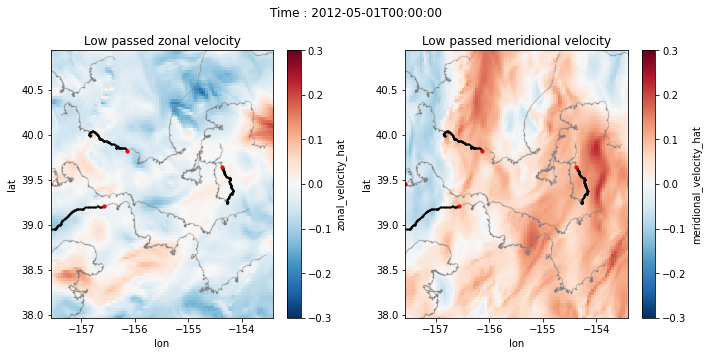

In [56]:
gen_fig_low(_df,15*24)

In [60]:
IT = np.arange(252,dsi.time.size,6)
for it in IT:
    gen_fig_low(_df,it,savefig=True)

In [53]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
